# Deep Learning / LGBM for unbalanced datasets

The kernel is not yet fully constructed :D  any comments are appreciated (added motivation <3)

Feel free to fork and test the presented models

1. [Sampling](#sample)
2. [Feature Engineering](#fe)
3. [LGBM Model](#lgbm)
4. [Keras Model](#keras)
5. [Combination Vis](#vis)
6. [Submission](#sub)

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout, BatchNormalization
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import  train_test_split
from keras import backend as K
from keras import optimizers
import keras as k
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
%time
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
print('Training df shape',df_train.shape)
print('Test df shape',df_test.shape)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs
Training df shape (200000, 202)
Test df shape (200000, 201)


In [3]:
#Setting up Data
per = len(df_train[df_train['target'] > 0]) / df_train.shape[0]
print('Percentage of transactions greater than 0 :   {} %'.format(per*100 ))

Percentage of transactions greater than 0 :   10.049 %


## Sampling from the full dataset (more work on this later)
<a id='sample'></a>

In [4]:
df_ones = df_train[df_train['target'] > 0]
print('Ones',df_ones.shape)
df_zeros = df_train[df_train['target'] == 0].sample(frac=0.109)
print('Zeros',df_zeros.shape)
#we concat both to the sampling dataframe
df_sampling = pd.concat([df_ones, df_zeros])
print(df_sampling.shape)

Ones (20098, 202)
Zeros (19609, 202)
(39707, 202)


## Simple Feature Engineering
<a id='fe'></a>

In [5]:
#Inspired by Gabriel Preda 's Kernel'
%time
idx = features = df_train.columns.values[2:202]
for i,df in enumerate([df_train, df_test,df_sampling]):
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)
    print('Creating percentiles features for df: {}/{}'.format(i+1,3))
    df['perc_5'] =  df[idx].apply(lambda x: np.percentile(x, 10), axis=1)
    df['perc_10'] =  df[idx].apply(lambda x: np.percentile(x, 10), axis=1)
    df['perc_25'] =  df[idx].apply(lambda x: np.percentile(x, 25), axis=1)
    df['perc_50'] =  df[idx].apply(lambda x: np.percentile(x, 50), axis=1)
    df['perc_75'] =  df[idx].apply(lambda x: np.percentile(x, 75), axis=1)
    df['perc_95'] =  df[idx].apply(lambda x: np.percentile(x, 99), axis=1)
    df['perc_99'] =  df[idx].apply(lambda x: np.percentile(x, 99), axis=1)    

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs
Creating percentiles features for df: 1/3
Creating percentiles features for df: 2/3
Creating percentiles features for df: 3/3


In [6]:
X = df_train.iloc[:,2:]
y = df_train['target']

#test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6666)

#Sampling train test split
X_smple = df_sampling.iloc[:,2:]
y_smple = df_sampling['target']
X_train_smple, X_test_smple, y_train_smple, y_test_smple = train_test_split(X_smple, y_smple, test_size=0.3, random_state=66)

# 1. LGBM Model
<a id='lgbm'></a>

In [7]:
#Model LGBM 
def create_model_lgbm(X_train,y_train,X_val=None,y_val=None):
    dtrain = lgb.Dataset(X_train,label=y_train)
    dval = lgb.Dataset(X_val,label=y_val)
    param = {
    'bagging_freq': 3,
    'bagging_fraction': 0.5,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.1,
    'learning_rate': 0.01,
    'max_depth': 2,  
    'metric':'auc',
    'min_data_in_leaf': 100,
    'num_leaves': 35,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
    }
    if not X_val is None:
        valid_sets = (dtrain,dval)
        valid_names = ['train','valid']
    else:
        valid_sets = (dtrain)
        valid_names = ['train']
    model = lgb.train(param,dtrain,num_boost_round=50000,valid_sets=valid_sets,valid_names=['train','valid'],
                      verbose_eval=1000,
                     early_stopping_rounds=1000)
    return model

lgbm_X = X
lgbm_y = y
lgbm_test_x = X_test
lgbm_test_y = y_test
val_pred = np.zeros(len(lgbm_X))
full_pred = np.zeros(len(X))
test_pred_lgbm = np.zeros(len(lgbm_test_y))
target_pred = np.zeros(len(df_test))
kf = KFold(n_splits=5,random_state=67)
for _fold, (trn_idx, val_idx) in enumerate(kf.split(lgbm_X.values, lgbm_y.values)):   
        Xtrn, ytrn = lgbm_X.iloc[trn_idx], lgbm_y.iloc[trn_idx]
        Xval, y_val = lgbm_X.iloc[val_idx], lgbm_y.iloc[val_idx]
        print("Fold num:{}".format(_fold + 1))
        clf = create_model_lgbm(Xtrn,ytrn,Xval,y_val)
        val_pred[val_idx] = clf.predict(lgbm_X.iloc[val_idx])
        test_pred_lgbm  += clf.predict(lgbm_test_x) / kf.n_splits
        full_pred += clf.predict(X) / kf.n_splits
        target_pred += clf.predict(df_test.iloc[:,1:]) / kf.n_splits

print('\nFull Training Data score {}'.format(roc_auc_score(y, full_pred)))        
print('Val CV score : {}'.format(roc_auc_score(lgbm_y, val_pred)))    
print('Test CV score : {}'.format(roc_auc_score(lgbm_test_y, test_pred_lgbm)))

Fold num:1
Training until validation scores don't improve for 1000 rounds.
[1000]	train's auc: 0.835567	valid's auc: 0.822856
[2000]	train's auc: 0.868414	valid's auc: 0.852877
[3000]	train's auc: 0.884654	valid's auc: 0.867295
[4000]	train's auc: 0.894449	valid's auc: 0.875671
[5000]	train's auc: 0.900904	valid's auc: 0.880994
[6000]	train's auc: 0.905702	valid's auc: 0.885005
[7000]	train's auc: 0.909326	valid's auc: 0.888211
[8000]	train's auc: 0.912178	valid's auc: 0.890515
[9000]	train's auc: 0.914438	valid's auc: 0.892397
[10000]	train's auc: 0.916357	valid's auc: 0.893827
[11000]	train's auc: 0.91795	valid's auc: 0.895002
[12000]	train's auc: 0.919378	valid's auc: 0.896024
[13000]	train's auc: 0.920664	valid's auc: 0.896682
[14000]	train's auc: 0.921784	valid's auc: 0.897149
[15000]	train's auc: 0.922828	valid's auc: 0.897615
[16000]	train's auc: 0.923783	valid's auc: 0.89795
[17000]	train's auc: 0.924715	valid's auc: 0.898187
[18000]	train's auc: 0.925614	valid's auc: 0.898325


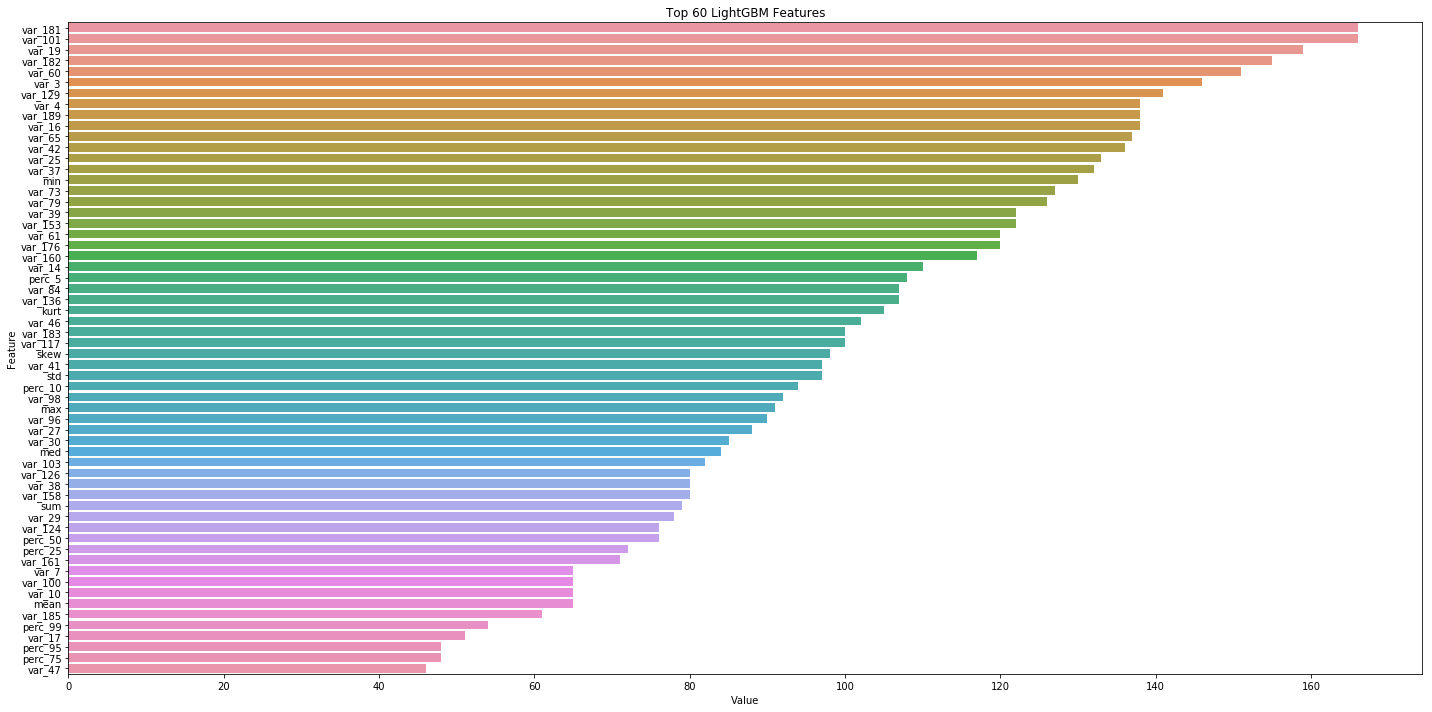

<Figure size 432x288 with 0 Axes>

In [8]:
num_features = 60
indxs = np.argsort(clf.feature_importance())[:num_features]
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance()[indxs],X.columns[indxs])), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Top {} LightGBM Features'.format(num_features))
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances.png')

As we can see , many of the engineered features are present within the top 60 important features

# 2.Keras NN Model
<a id='keras'></a>

In [9]:
from keras.callbacks import EarlyStopping

def auc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

#Model NN definition
def create_model_nn(in_dim,layer_size=120):
    model = Sequential()
    model.add(Dense(layer_size,input_dim=in_dim))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(layer_size))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(layer_size))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(layer_size))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(1, activation='sigmoid'))
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=adam,loss='binary_crossentropy',metrics = [auc])    
    return model

model_nn = create_model_nn(X_train.shape[1])
callback = EarlyStopping("val_loss", patience=6, verbose=0, mode='auto')
history = model_nn.fit(X_train, y_train, validation_data = (X_test,y_test),epochs=100,batch_size=256,verbose=1,callbacks=[callback])
target_pred_nn = model_nn.predict(df_test.iloc[:,1:])[:,0]
print('\nNon-Sampled Validation Max score : {}'.format(np.max(history.history['val_auc'])))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Instructions for updating:
Use tf.cast instead.
Train on 140000 samples, validate on 60000 samples
Epoch 1/100
140000/140000 [==============================] - 10s 74us/step - loss: 0.3354 - auc: 0.6047 - val_loss: 0.2829 - val_auc: 0.7721
Epoch 2/100
140000/140000 [==============================] - 9s 64us/step - loss: 0.2743 - auc: 0.7870 - val_loss: 0.2550 - val_auc: 0.8408

## Combination Vis
<a id='vis'></a>

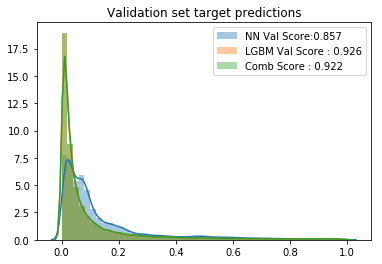

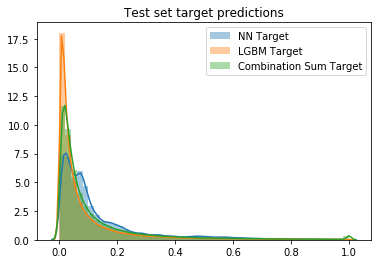

<Figure size 432x288 with 0 Axes>

In [10]:
#Ditribution Plots from both models 
nn_val_pred = model_nn.predict(X_test)[:,0]
lgbm_val_pred  = test_pred_lgbm
comb_approach_test = (0.2*target_pred_nn+target_pred)
comb_approach_test[comb_approach_test>1]=1
comb_approach_test[comb_approach_test<0]=0

comb_approach_val = (0.2*nn_val_pred+lgbm_val_pred)
comb_approach_val[comb_approach_val>1]=1
comb_approach_val[comb_approach_val<0]=0

#validations sets
sns.distplot(nn_val_pred,label='NN Val Score:{:.3f}'.format(roc_auc_score(y_test,nn_val_pred)))
sns.distplot(lgbm_val_pred,label='LGBM Val Score : {:.3f}'.format(roc_auc_score(lgbm_test_y, test_pred_lgbm)))
sns.distplot(lgbm_val_pred,label='Comb Score : {:.3f}'.format(roc_auc_score(lgbm_test_y, comb_approach_val)))
plt.title('Validation set target predictions')
plt.legend()
plt.show()
plt.savefig('combination_val.png')
#target final test set
sns.distplot(target_pred_nn,label='NN Target')
sns.distplot(target_pred,label='LGBM Target')
sns.distplot(comb_approach_test,label='Combination Sum Target')
plt.title('Test set target predictions')
plt.legend()
plt.show()
plt.savefig('combination_target_test.png')

We can in the above plots, for the validation distplot plot we have two peaks one corresponding to 1 and the other to zero. Which is expected due to the fact that we are using a sampling approach that does not suffer from the imbalanced classes problem. it is also telling us that NN model is predicting more zeros than ones.

When we use the models to predict the target test set only one peak is observed which is also expected.

# Submission
<a id='sub'></a>

In [11]:
def sub_pred(preds,df_test,name='submission.csv'):
    sub_df = pd.DataFrame({'ID_code':df_test['ID_code'],'target':preds})
    sub_df.to_csv(name, index=False)
    
sub_pred(target_pred,df_test,name='lgbm_submission.csv')

More work will be done regarding a combination approach :) Thank you.